# Frame interpolation using FILM and OpenVINO
[Frame interpolation](https://en.wikipedia.org/wiki/Motion_interpolation) is the process of synthesizing in-between images from a given set of images. The technique is often used for [temporal up-sampling](https://en.wikipedia.org/wiki/Frame_rate#Frame_rate_up-conversion) to increase the refresh rate of videos or to create slow motion effects. Nowadays, with digital cameras and smartphones, we often take several photos within a few seconds to capture the best picture. Interpolating between these “near-duplicate” photos can lead to engaging videos that reveal scene motion, often delivering an even more pleasing sense of the moment than the original photos.

![](https://github.com/googlestaging/frame-interpolation/raw/main/moment.gif)

In ["FILM: Frame Interpolation for Large Motion"](https://arxiv.org/pdf/2202.04901.pdf), published at ECCV 2022, a method to create high quality slow-motion videos from near-duplicate photos is presented. FILM is a new neural network architecture that achieves state-of-the-art results in large motion, while also handling smaller motions well.

The FILM model takes two images as input and outputs a middle image. At inference time, the model is recursively invoked to output in-between images. FILM has three components:
  1. Feature extractor that summarizes each input image with deep multi-scale (pyramid) features;
  2. Bi-directional motion estimator that computes pixel-wise motion (i.e., flows) at each pyramid level;
  3. Fusion module that outputs the final interpolated image.

FILM is trained on regular video frame triplets, with the middle frame serving as the ground-truth for supervision.

In this tutorial, we will use [TensorFlow Hub](https://tfhub.dev/) as a model source.
### Table of content:
- [Prerequisites](#Prerequisites-Uparrow)
- [Prepare images](#Prepare-images-Uparrow)
- [Load the model](#Load-the-model-Uparrow)
- [Infer the model](#Infer-the-model-Uparrow)
    - [Single middle frame interpolation](#Single-middle-frame-interpolation-Uparrow)
    - [Recursive frame generation](#Recursive-frame-generation-Uparrow)
- [Convert the model to OpenVINO IR](#Convert-the-model-to-OpenVINO-IR-Uparrow)
- [Inference](#Inference-Uparrow)
    - [Select inference device](#Select-inference-device-Uparrow)
    - [Single middle frame interpolation](#Single-middle-frame-interpolation-Uparrow)
    - [Recursive frame generation](#Recursive-frame-generation-Uparrow)
- [Interactive inference](#Interactive-inference-Uparrow)


## Prerequisites [$\Uparrow$](#Table-of-content:)


In [1]:
%pip install -q tensorflow tensorflow_hub numpy "opencv-python" tqdm matplotlib gradio Pillow
%pip uninstall -q -y openvino
%pip install -q -I openvino_nightly


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
from urllib.request import urlretrieve
from typing import Optional, Generator, Iterable
from datetime import datetime
import gc


import tensorflow_hub as hub
import tensorflow as tf
import openvino as ov
import ipywidgets
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gradio as gr
import PIL
import IPython

2023-11-02 11:23:42.519606: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 11:23:42.521340: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 11:23:42.549839: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 11:23:42.549860: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 11:23:42.549882: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
MODEL_PATH = Path("models/model.xml")
DATA_PATH = Path("data")
IMAGES = {
    "https://raw.githubusercontent.com/google-research/frame-interpolation/main/photos/one.png": Path("data/one.png"),
    "https://raw.githubusercontent.com/google-research/frame-interpolation/main/photos/two.png": Path("data/two.png")
}
OUTPUT_VIDEO_PATH = DATA_PATH / "output.webm"
OV_OUTPUT_VIDEO_PATH = DATA_PATH / "ov_output.webm"
TIMES_TO_INTERPOLATE = 5
DATA_PATH.mkdir(parents=True, exist_ok=True)

PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True  # allows Gradio to read PNG images with large metadata

## Prepare images [$\Uparrow$](#Table-of-content:)
Download images and cast them to NumPy arrays to provide as model inputs.

In [4]:
def prepare_input(img_url: str):
    if not IMAGES[img_url].exists():
        urlretrieve(img_url, IMAGES[img_url])
    filename = str(IMAGES[img_url])
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img)
    img = img.astype(np.float32) / img.max()  # normalize image to [0, 1] interval
    img = img[np.newaxis, ...]  # add batch dimension
    
    return img

input_images = [prepare_input(url) for url in IMAGES]

input = {
    "x0": input_images[0],
    "x1": input_images[1],
    "time": np.array([[0.5]], dtype=np.float32)
}

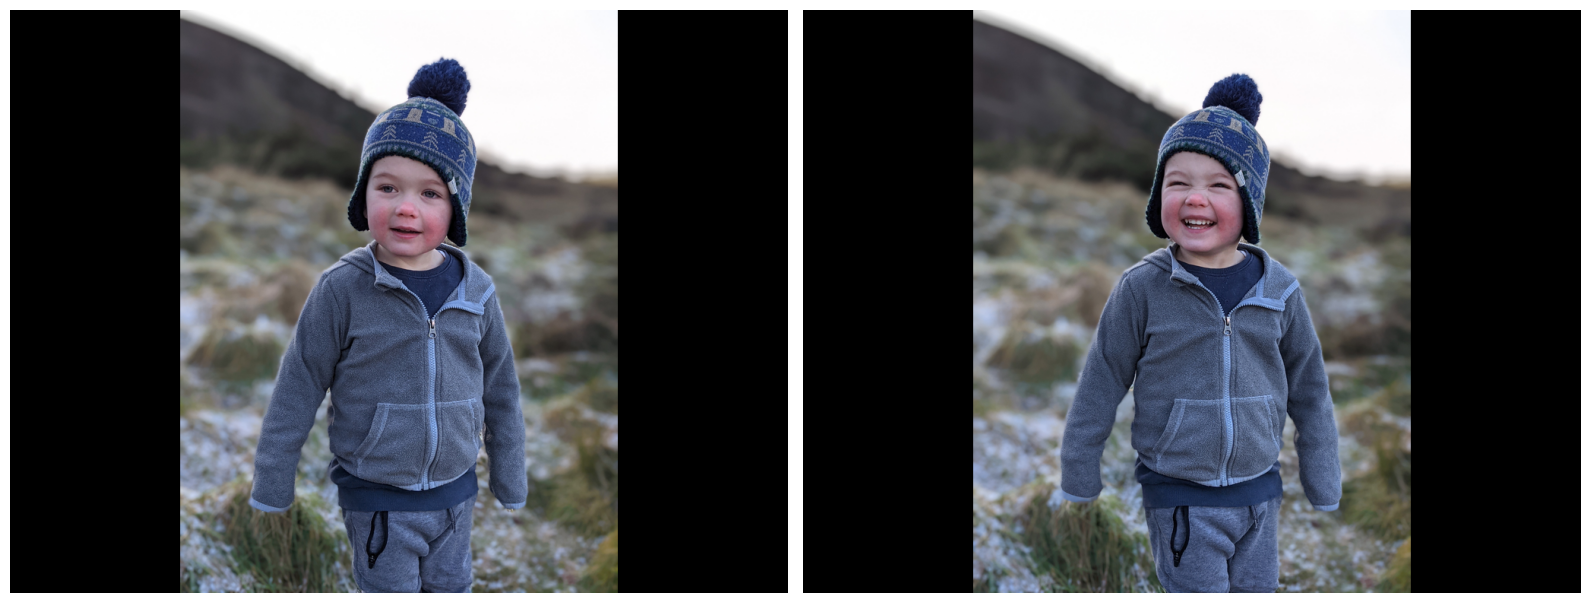

In [5]:
plt.figure(figsize=(16, 8), layout="tight")
plt.subplot(1, 2, 1)
plt.imshow(input_images[0][0])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(input_images[1][0])
plt.axis("off");

## Load the model [$\Uparrow$](#Table-of-content:)
Model is loaded using `tensorflow_hub.KerasLayer` function. Then, we specify shapes of input tensors to cast loaded object to `tf.keras.Model` class.

Input tensors are:
- `time` - value between $[0,1]$ that says where the generated image should be. $0.5$ is midway between the input images.
- `x0` - initial frame.
- `x1` - final frame.

For more details, see [model page on TensorFlow Hub](https://tfhub.dev/google/film/1).

In [6]:
inputs = dict(
    x0=tf.keras.layers.Input(shape=(None, None, 3)),
    x1=tf.keras.layers.Input(shape=(None, None, 3)),
    time=tf.keras.layers.Input(shape=(1)),
)
film_layer = hub.KerasLayer("https://tfhub.dev/google/film/1")(inputs)
film_model = tf.keras.Model(inputs=inputs, outputs=film_layer)

## Infer the model [$\Uparrow$](#Table-of-content:)


### Single middle frame interpolation [$\Uparrow$](#Table-of-content:)


In [7]:
output = film_model(input)
interpolated_image = output["image"][0]
interpolated_image = np.clip(interpolated_image, 0, 1)

In [8]:
def draw(img1, mid_img, img2):
    title2img = {"First frame": img1, "Interpolated frame": mid_img, "Last frame": img2}
    plt.figure(figsize=(16,8), layout="tight")
    for i, (title, img) in enumerate(title2img.items()):
        ax = plt.subplot(1, 3, i + 1)
        ax.set_title(title)
        plt.imshow(img)
        plt.axis("off")

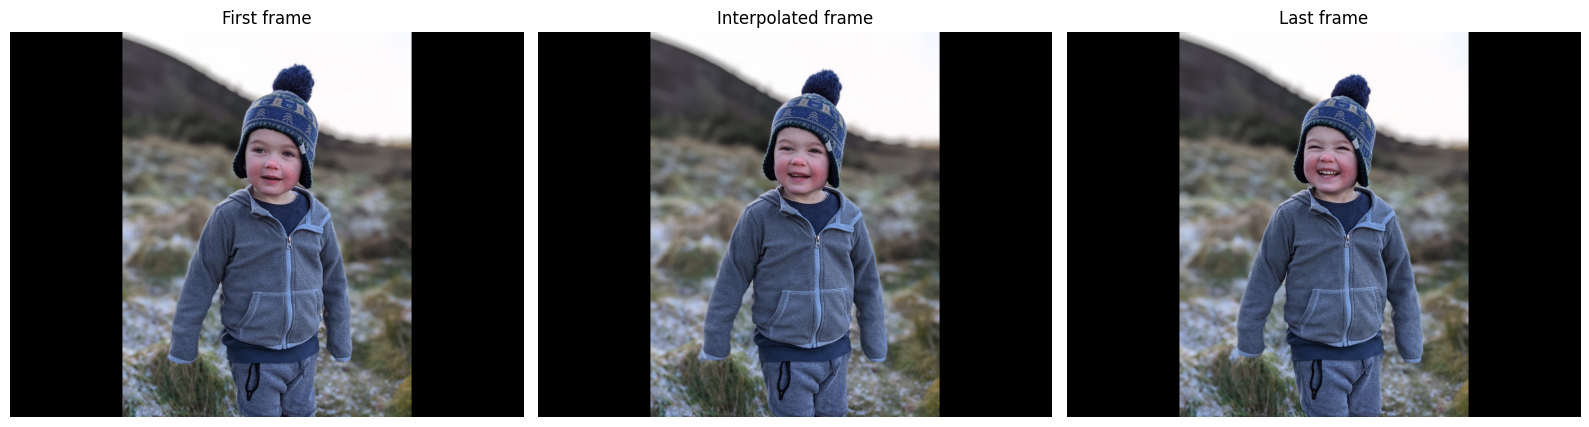

In [9]:
draw(input_images[0][0], interpolated_image, input_images[1][0])

### Recursive frame generation [$\Uparrow$](#Table-of-content:)
The process will take as input 2 original frames (first and last) and generate a midpoint frame. Then, it will repeat itself for pairs "first - midpoint", "midpoint - last" to provide midpoints for them, and so on. Recursion is executed $t=$ `times_to_interpolate` times generating $2^t-1$ images.

In [10]:
class Interpolator:
    def __init__(self, model_fn):
        self._model_fn = model_fn

    def _recursive_generator(
        self,
        frame1: np.ndarray,
        frame2: np.ndarray,
        num_recursions: int,
        bar: Optional[tqdm] = None,
    ) -> Generator[np.ndarray, None, None]:
        """Splits halfway to repeatedly generate more frames.

        Args:
          frame1: Input image 1.
          frame2: Input image 2.
          num_recursions: How many times to interpolate the consecutive image pairs.

        Yields:
          The interpolated frames, including the first frame (frame1), but excluding
          the final frame2.
        """
        if num_recursions == 0:
            yield frame1
        else:
            time = np.array([[0.5]], dtype=np.float32)
            mid_frame = self._model_fn(frame1, frame2, time)
            bar.update(1) if bar is not None else bar
            yield from self._recursive_generator(frame1, mid_frame, num_recursions - 1, bar)
            yield from self._recursive_generator(mid_frame, frame2, num_recursions - 1, bar)

    def interpolate_recursively(
        self, frame1: np.ndarray, frame2: np.ndarray, times_to_interpolate: int
    ) -> Iterable[np.ndarray]:
        """Generates interpolated frames by repeatedly interpolating the midpoint.

        Args:
          frame1: Input image 1.
          frame2: Input image 2.
          times_to_interpolate: Number of times to do recursive midpoint
            interpolation.

        Yields:
          The interpolated frames (including the inputs).
        """
        num_frames = 2 ** (times_to_interpolate) - 1
        bar = tqdm(total=num_frames)
        yield from self._recursive_generator(frame1, frame2, times_to_interpolate, bar)
        # Separately yield the final frame.
        yield frame2

In [11]:
def save_as_video(frames: Generator[np.ndarray, None, None], width: int, height: int, filename: Path):
    out = cv2.VideoWriter(str(filename), cv2.VideoWriter_fourcc(*'VP90'), 30, (width, height))
    for frame in frames:
        img = frame[0]
        img = np.clip(img, 0, 1)
        rgb_img = img * 255
        rgb_img = rgb_img.astype(np.uint8)
        bgr_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
        out.write(bgr_img)
    out.release()

In [12]:
height, width = input_images[0][0].shape[:2]
interpolator = Interpolator(lambda frame1, frame2, time: film_model({"x0": frame1, "x1": frame2, "time": time})["image"]) 
frames = interpolator.interpolate_recursively(input_images[0], input_images[1], TIMES_TO_INTERPOLATE)
save_as_video(frames, width, height, OUTPUT_VIDEO_PATH)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


  0%|          | 0/31 [00:00<?, ?it/s]

In [13]:
IPython.display.Video(filename=OUTPUT_VIDEO_PATH, embed=True)

## Convert the model to OpenVINO IR [$\Uparrow$](#Table-of-content:)
To convert a TensorFlow Keras Model to OpenVINO Intermediate Representation (IR), call the `openvino.convert_model()` function and pass the model as the only argument. You can then serialize the model object to disk using the `openvino.save_model()` function.

In [14]:
if not MODEL_PATH.exists():
    converted_model = ov.convert_model(film_model)
    ov.save_model(converted_model, MODEL_PATH)
    del converted_model
del film_model
gc.collect()

100834

## Inference [$\Uparrow$](#Table-of-content:)


### Select inference device [$\Uparrow$](#Table-of-content:)
select device from dropdown list for running inference using OpenVINO

In [15]:
core = ov.Core()
device = ipywidgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)
device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

In [16]:
compiled_model = core.compile_model(MODEL_PATH, device.value)

### Single middle frame interpolation [$\Uparrow$](#Table-of-content:)
Model output has multiple tensors, including auxiliary inference data. The main output tensor - interpolated image - is stored at "image" key.

In [17]:
result = compiled_model(input)["image"]
image = result[0]
image = np.clip(image, 0, 1)

Model returned intermediate image. Let's see what it is.

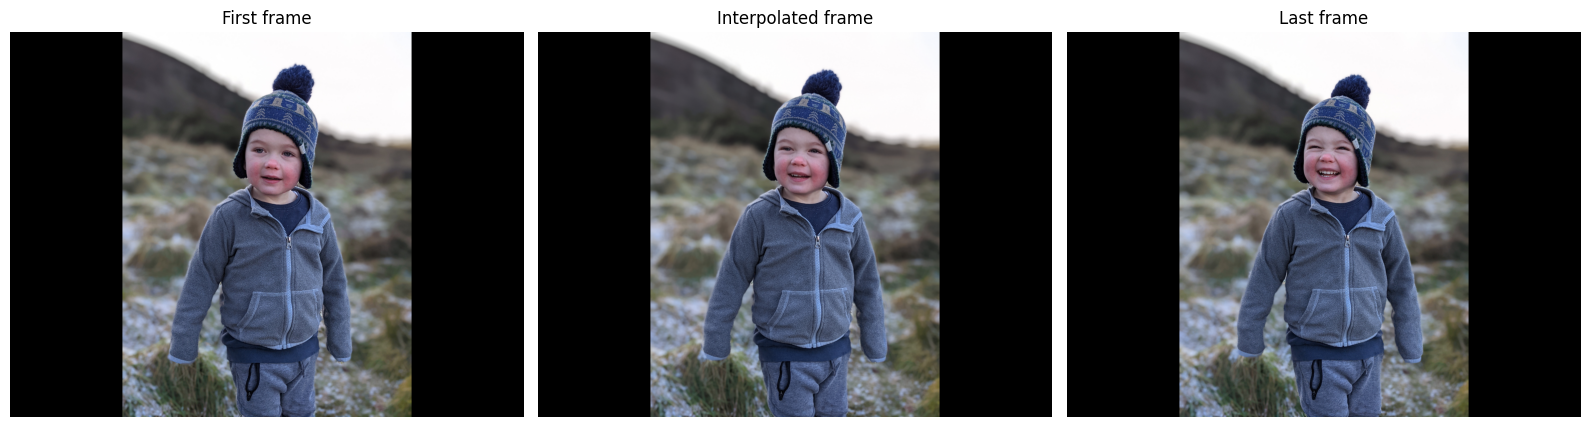

In [18]:
draw(input_images[0][0], image, input_images[1][0])

### Recursive frame generation [$\Uparrow$](#Table-of-content:)
Now let's create a smooth video by recursively generating frames between initial, middle and final images.

In [19]:
height, width = input_images[0][0].shape[:2]
ov_interpolator = Interpolator(lambda frame1, frame2, time: compiled_model({"x0": frame1, "x1": frame2, "time": time})["image"])
frames = ov_interpolator.interpolate_recursively(input_images[0], input_images[1], TIMES_TO_INTERPOLATE)
save_as_video(frames, width, height, OV_OUTPUT_VIDEO_PATH)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


  0%|          | 0/31 [00:00<?, ?it/s]

In [20]:
IPython.display.Video(filename=OV_OUTPUT_VIDEO_PATH, embed=True)

## Interactive inference [$\Uparrow$](#Table-of-content:)


In [21]:
def generate(frame1, frame2, times_to_interpolate, _=gr.Progress(track_tqdm=True)):
    height, width = frame1.shape[:2]
    frame1 = frame1.astype(np.float32) / 255  # normalize to [0, 1]
    frame2 = frame2.astype(np.float32) / 255
    frame1 = frame1[np.newaxis, ...]  # add batch dim
    frame2 = frame2[np.newaxis, ...]
    filename = DATA_PATH / f"output_{datetime.now().isoformat()}.webm"
    frames = ov_interpolator.interpolate_recursively(frame1, frame2, times_to_interpolate)
    save_as_video(frames, width, height, filename)
    return filename

demo = gr.Interface(
    generate,
    [
        gr.Image(label="First image"),
        gr.Image(label="Last image"),
        gr.Slider(1, 8, step=1, label="Times to interpolate", info="""Controls the number of times the frame interpolator is invoked.
        The output will be the interpolation video with (2^value + 1) frames, fps of 30.""")
    ],
    gr.Video(),
    examples=[[*IMAGES.values(), 5]],
    allow_flagging="never"
)
try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/